<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Imports" data-toc-modified-id="Data-Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Imports</a></span></li><li><span><a href="#Data-Examination" data-toc-modified-id="Data-Examination-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Examination</a></span><ul class="toc-item"><li><span><a href="#Photos" data-toc-modified-id="Photos-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Photos</a></span></li><li><span><a href="#Label-distribution" data-toc-modified-id="Label-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Label distribution</a></span></li></ul></li><li><span><a href="#Network-implementation" data-toc-modified-id="Network-implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network implementation</a></span></li></ul></div>

# Bird Classifier

Built using the Kaggle sourced <a href=https://www.kaggle.com/datasets/gpiosenka/100-bird-species>dataset</a> of 525 bird species.

## Data Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

from tqdm.notebook import tqdm

import pickle
from contextlib import nullcontext
import os

/home/metal_undivided/anaconda3/envs/practicum_souped/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [4]:
batch_size = 16

In [5]:
data_dir = '/media/metal_undivided/DATA/Datasets/Kaggle_525_species/'
if not os.path.exists(data_dir):
    data_dir = '/media/metal_undivided/Samsung_T5/Datasets/Bird_Images_525_Species/'

train_dataset = datasets.ImageFolder(data_dir + 'train/', transform=transform)
val_dataset = datasets.ImageFolder(data_dir + 'valid/', transform=transform)
test_dataset = datasets.ImageFolder(data_dir + 'test/', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
#next(iter(train_dataloader))[0]

The data is successfully imported, let's examine it.

## Data Examination

### Photos

In [7]:
pixels, labels = next(iter(train_dataloader))

Let's also get the label-species pairs for visualisation.

In [8]:
species = train_dataset.find_classes(data_dir + 'train/')
species = {label:name for name, label in species[1].items()}

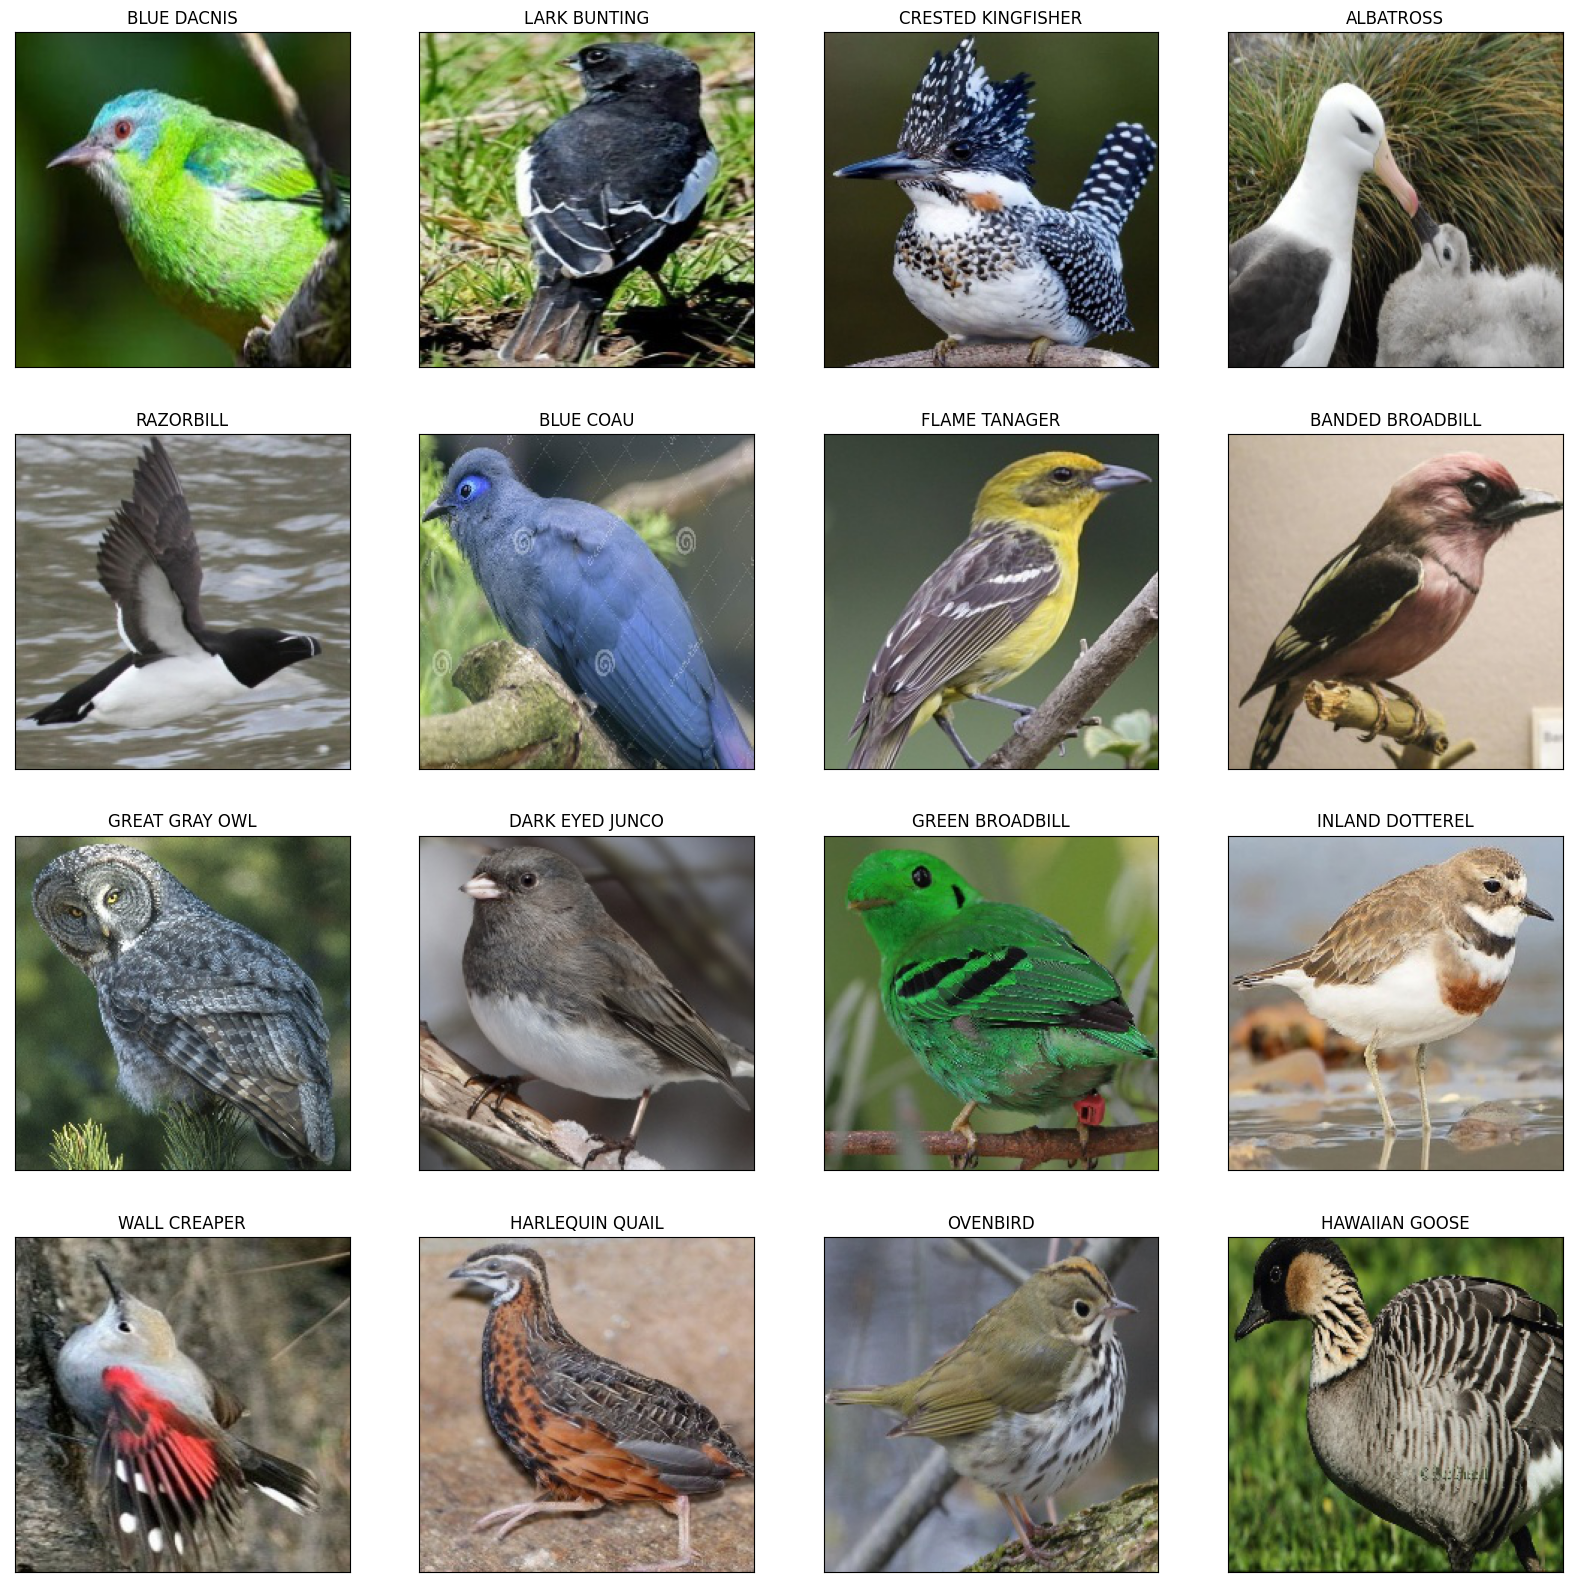

In [9]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i in range(16):
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels[i].permute(1, 2, 0))
    axobject.set_title(species[labels.numpy()[i]])
    axobject.get_xaxis().set_visible(False)
    axobject.get_yaxis().set_visible(False)

Looks good, both the names and the images.

Before implementing the network, let's see how many photos of each bird we have.

### Label distribution

Since iterating over all the classes is fairly time consuming, this section is normally omitted and counts precalculated here are used instead.

```python
species_count = torch.zeros(525)
species_count.requires_grad = False

for counter, batch in enumerate(tqdm(train_dataloader)):
    _, labels = batch
    species_count += nn.functional.one_hot(labels, num_classes=525).sum(axis=0)    
    
```

```python
torch.save(species_count, 'species_count')
```

Loading precalculated counts

In [10]:
species_count = torch.load('species_count')

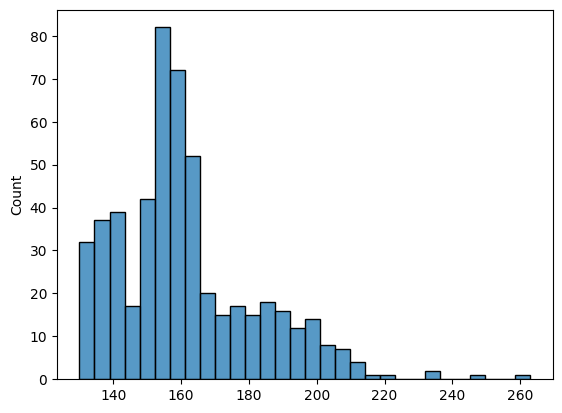

In [11]:
sns.histplot(species_count.numpy(), bins=30);

Most of the classes are fairly equally represented, save for a few outliers.

In order to improve learning, we'll use the inverse of these counts as class weights.

## Network implementation

For this task I'll be implementing a ResNet network.

Since ResNet bottleneck blocks are identical for all of ResNet50+ family, I'll first define them as their own class.

In [12]:
class ResNet(nn.Module):
    
    def __init__(self, n_labels, freeze_layers=False):
        super(ResNet, self).__init__()
        
        self.freeze_layers = freeze_layers
        
        self.base = nn.Conv2d(3, 64, (7, 7), stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        
        self.block1 = self.ResNetLayer(BottleneckBlock, 64, 64, 256, 3)
        self.block2 = self.ResNetLayer(BottleneckBlock, 256, 128, 512, 4)
        self.block3 = self.ResNetLayer(BottleneckBlock, 512, 256, 1024, 6)
        self.block4 = self.ResNetLayer(BottleneckBlock, 1024, 512, 2048, 3)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(2048, n_labels, bias=True)
        
        
    
    def forward(self, x):
        
        with torch.no_grad() if self.freeze_layers else nullcontext():
        
            x = self.base(x)
            x = self.bn1(x)
            x = nn.ReLU()(x)
            x = self.pool(x)

            x = self.block1(x)
            x = self.block2(x)
            #print(x)
            x = self.block3(x)
            x = self.block4(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            
        x = self.linear(x)
        #x = nn.Softmax(dim=1)(x)
        
        return x
    
    
    def ResNetLayer(self, block, input_channels, interm_channels, output_channels, repetitions, first_layer=False):
        
        layer = nn.Sequential()
        
        layer.append(block(input_channels, interm_channels, output_channels, stride=2, residual_downsample=True))
        
        for repetition in range(repetitions - 1):
            layer.append(block(output_channels, interm_channels,output_channels))
        
        return layer

Now that the main architecture is described, I need to implement the main building block for the model - the bottleneck block.

In [13]:
class BottleneckBlock(nn.Module):
    
    def __init__(self, input_channels, interm_channels, output_channels, stride=1, residual_downsample=False):
        super(BottleneckBlock, self).__init__()
        self.input_channels = input_channels
        self.interm_channels = interm_channels
        self.output_channels = output_channels
        self.residual_downsample = residual_downsample
        
        self.layer1 = nn.Conv2d(input_channels, interm_channels, (1, 1), stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(interm_channels)
        self.layer2 = nn.Conv2d(interm_channels, interm_channels, (3, 3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(interm_channels)
        self.layer3 = nn.Conv2d(interm_channels, output_channels, (1, 1), stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        if residual_downsample:
            self.residual = nn.Conv2d(input_channels, output_channels, (1, 1), stride=stride, bias=False)
            self.res_bn = nn.BatchNorm2d(output_channels)
        
        
    def forward(self, x):
        
        x_init = x
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = self.bn3(x)
        
        if self.residual_downsample:
            x_init = self.residual(x_init)
            x_init = self.res_bn(x_init)
            x += x_init
        else:
            x+= x_init
            
        x = nn.ReLU()(x)
        
        return x
    

In [14]:
def fit_batch(model, features, target, optimizer, loss_fn):
    
    optimizer.zero_grad(set_to_none=True)
    
    predictions = model(features)
    
    loss = loss_fn(predictions, target)
    loss.backward()
    
    optimizer.step()
    
    return loss

Since the dataset is fairly light (around 200 images per class), it's unlikely that the model will learn to generalize well enough, so I'll be performing transfer learning and finetuning the model for our specific dataset.

This time I'll be using IMAGENET weights (1000 classes, ~1.2kk training images).

In [15]:
pretrained_weights = models.resnet50(weights="IMAGENET1K_V2").state_dict()

In [16]:
model = ResNet(n_labels=525)
#model = models.resnet50(weights="DEFAULT")

## transfer learning
model.load_state_dict(pretrained_weights, strict=False)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()#weight=(species_count.mean() / species_count) ** 2)

```python
for param in model.parameters():
    param.requires_grad = False
```

In [17]:
## replacing last layer pretrained weights with random values
model.linear = nn.Linear(model.linear.in_features, 525)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,583,757 trainable parameters


```python
report_every = 1000
best_accuracy = 0
best_weights = None

model.train(True)

for epoch in range(10):

    ## training
    running_loss_train = 0
    total_loss_train = 0
    correct_labels_train = 0
    for counter_train, batch_train in enumerate(tqdm(train_dataloader, desc="Training")):

        pixels_train, labels_train = batch_train

        running_loss_train += fit_batch(model, pixels_train, labels_train, optimizer, loss_fn).item() 

        if counter_train % report_every == (report_every - 1):
            running_loss_train = running_loss_train / len(batch_train) / report_every
            print('Batch {1} loss: {0:.8f}'.format(running_loss_train, counter_train + 1))
            
            total_loss_train += running_loss_train
            running_loss_train = 0
            
        ## training accuracy
        with torch.no_grad():
            predictions_train = torch.max(model(pixels_train), dim=1)[1]
            predictions_train = torch.sum(predictions_train == labels_train)
            correct_labels_train += predictions_train
            
    print(f'Epoch {epoch + 1} training average loss: {total_loss_train / (counter_train + 1) * (counter_train % report_every)}')
    print(f'Epoch {epoch + 1} training accuracy: {correct_labels_train / ((counter_train + 1) * batch_size):.6%}')
    
            
    ## validation
    with torch.no_grad():
        
        correct_labels_val = 0
        total_loss_val = 0
        
        for counter_val, batch_val in enumerate(tqdm(val_dataloader, desc="Validation")):
            
            pixels_val, labels_val = batch_val
            
            total_loss_val += loss_fn(model(pixels_val), labels_val).item() 
            
            ## all predictions
            predictions_val = torch.max(model(pixels_val), dim=1)[1]
            ## number of correct predictions
            predictions_val = torch.sum(predictions_val == labels_val)
            correct_labels_val += predictions_val
    
    accuracy_val = correct_labels_val / ((counter_val + 1) * batch_size)
    
    if accuracy_val > best_accuracy:
        best_weights = model.state_dict()
        best_accuracy = accuracy_val
    
    print(f'Epoch {epoch + 1} validation average loss: {total_loss_val / (counter_val + 1)}')
    print(f'Epoch {epoch + 1} validation accuracy: {accuracy_val:.6%}')
    
model.load_state_dict(best_weights)
```

```python
torch.save(model, "ResNet50_imagenet_finetuned_bird_classifier.torch")
```

In [19]:
model = torch.load("ResNet50_imagenet_finetuned_bird_classifier.torch")